## 알고리즘 정해서 발표하기

1. PCA, KNN
2. 앙상블(Ensemble), 배깅(Bagging)
3. 부스팅(Bossting)

포함되어야 할 내용
- 개념 설명
- (앙상블, 배깅, 부스팅)의 경우 관련 모델
- 사이킷런 구현시 함수의 각 파라미터

```
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from matplotlib.colors import ListedColormap

def draw_decision_region(model, X, y, 
                         X_test=[], y_test=[], 
                         features=[], labels=[], title=''): # 결정경계

  colors = ('orangered', 'dodgerblue', 'limegreen', 'fuchsia', 'blueviolet')
  cmap = ListedColormap(colors[:len(np.unique( y))])

  x0mn, x0mx = X[:,0].min() -1, X[:,0].max() +1
  x1mn, x1mx = X[:,1].min() -1, X[:,1].max() +1
  x0 = np.arange(x0mn, x0mx, 0.02)
  x1 = np.arange(x1mn, x1mx, 0.02)
  #print('* arange', x0.shape, x1.shape)
  X0, X1 = np.meshgrid(x0, x1)
  #print('* meshgrid', x0.shape, x1.shape)
  x0, x1 = X0.ravel(), X1.ravel()
  #print('* ravel', x0.shape, x1.shape)
  x_every = np.array([x0, x1]).T
  #print('* concat', x_set.shape)
  y_pred = model.predict(x_every)
  #print('* y_pred', y_pred.shape)
  Y_pred = y_pred.reshape(X0.shape)
  #print('* y_pred', y_pred.shape)

  if not len(labels): labels=[i for i in range(len(np.unique(y)))]
  plt.contourf(X0, X1, Y_pred, alpha=0.4, cmap=cmap )
  for idx, c in enumerate(np.unique(y)):
    plt.scatter(x = X[y == c, 0], 
                y = X[y == c, 1],
                alpha=0.8,
                c=colors[idx],
                label=labels[idx],
                marker='x',
                linewidth=2)
  if len(X_test):
    for idx, c in enumerate(np.unique(y_test)):
      plt.scatter(x = X_test[y_test == c, 0], 
                  y = X_test[y_test == c, 1],
                  alpha=0.8,
                  c=colors[idx],
                  marker='o',
                  edgecolor='k',
                  linewidth=2)
  
  if features:
    plt.xlabel(features[0])
    plt.ylabel(features[1])
  if title:
    plt.title(title)
  plt.legend()

## 데이터 소개 : 와인 데이터셋
---


```
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
```

### 데이터 가져오기

In [6]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print(df_wine.shape)
df_wine.head()

(178, 14)


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [7]:
# X, y로 구분 + 넘파이로 변환
X = df_wine.drop('Class label', axis = 1).values
y = df_wine['Class label'].values
X.shape, y.shape

((178, 13), (178,))

* df_wine.isnull().sum() -> 누락데이터 없음
* df_wine.info() -> 전부 수치데이터

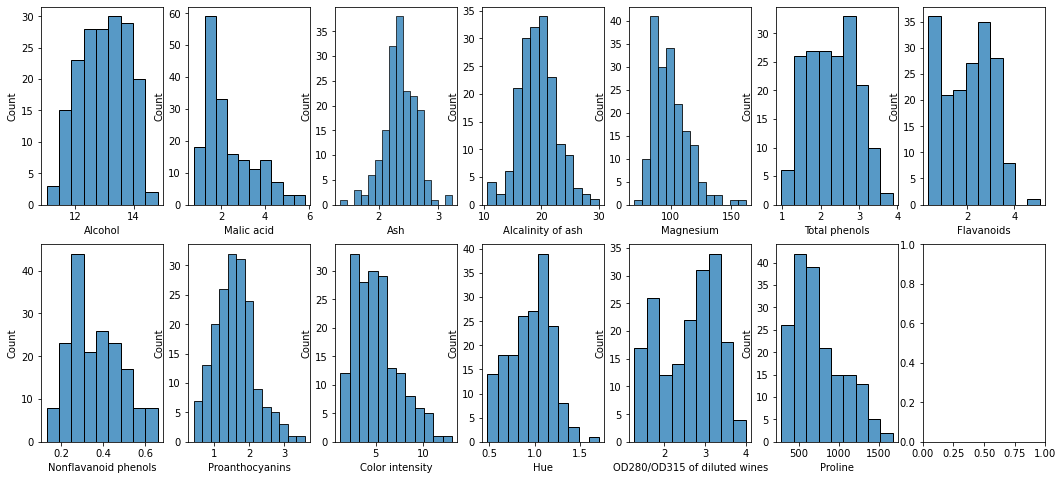

In [8]:
features = [ 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
fig, axes = plt.subplots(2, 7, figsize =(18,8))
axes = axes.flatten()
for feature,ax in zip(features, axes):
    sns.histplot(data = df_wine, x = feature, ax = ax)
plt.show()

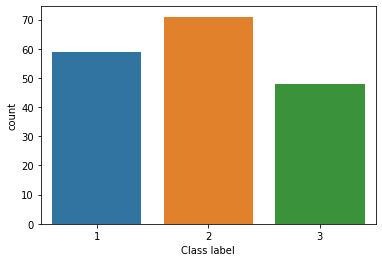

In [9]:
# 클래스(y)별 개수(countplot)
sns.countplot(data = df_wine, x = 'Class label')
plt.show()

### 전처리

In [10]:
# 라벨 인코딩 {1,2,3} -> {0,1,2}
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# 훈련-테스트 데이터 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

### 모델 파이프라인 제작
### 모델링 (파이프라인 없애면)

#### PCA 

```
sklearn.decomposition.PCA( n_components=None,
                           copy=True, 
                           whiten=False, 
                           svd_solver='auto', 
                           tol=0.0, 
                           iterated_power='auto', 
                           n_oversamples=10
                           power_iteration_normalizer='auto'
                           random_state=None)

* n_components=None {int,float,'mle'}

* copy=True, 

* whiten=False,

* svd_solver='auto' {'full', 'arpack', 'randomized'}

    - 'full' : LAPACK solver를 호출. 
    - 'arpack' :  ARPACK solver를 호출. 
    - 'randomized' : 랜덤 PCA라는 확률적 알고리즘을 사용할 때 호출.
    - 'auto' : 원본 데이터의 크기나 차원 수가 500보다 크고, 축소할 차원이 이것들의 80%보다 작으면 sklearn은 자동으로 랜덤 PCA 알고리즘을 사용

* tol=0.0 {float}
    svd_solver =="arpack"을 사용할 때, 특이값의 허용오차
    
* iterated_power='auto' {int}
    svd_solver == "randomized" 일 때 거듭제곱식 반복 횟수
    
* n_oversamples=10 {int}
    svd_solver == "randomized" 일 때 사용
    
* power_iteration_normalizer='auto' {'QR', 'LU', 'none'}
    svd_solver == "randomized 일때 사용
* random_state=None {int} 
    난수 값
```

#### KNN 
```
sklearn.neighbors.KNeighborsClassifier(n_neighbors=5,
                                       weights='uniform', 
                                       algorithm='auto', 
                                       leaf_size=30, 
                                       p=2, 
                                       metric='minkowski',
                                       metric_params=None, 
                                       n_jobs=None)


* n_neighbors=5 {int}

* weights='uniform' {‘uniform’, ‘distance’} or callable 

    - 'uniform': 각 이웃에 동일한 가중치를 준다.
    - ‘distance’: 가까운 이웃이 멀리 있는 이웃보다 더욱 큰 영향을 미친다.

* algorithm='auto' {'auto', 'ball_tree', 'kd_tree', 'brute'}

* leaf_size=30 {int}
    - 트리 알고리즘에서 총 가지 수
    
* p=2: {int}
    minkowski 의 매개변수
    - p = 1: 맨허튼 거리 공식 사용
    - p = 2: 유클리디안 거리 공식 사용

* metric='minkowski' {str or callable}

* metric_params=None {dict}

* n_jobs=None {int}
```

#### GridSearchCV를 이용한 하이퍼파라미터 튜닝

In [14]:
from sklearn.pipeline import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([("scaler", StandardScaler()),
                 ("pca", PCA(random_state=1, n_components=2)),
                 ("knn", KNeighborsClassifier())])

In [ ]:
model = KNeighborsClassifier()

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = [ {'pca__svd_solver' :  ["full","arpack","randomized"],
                'knn__n_neighbors':  np.arange(1,11),
                'knn__weights': ["uniform","distance"],
                'knn__leaf_size': [10,20,30,40,50],
                'knn__p' : [1,2]
                } ]

gs = GridSearchCV(estimator=pipe, # classifier, regressor, pipeline 등 가능
                  scoring="accuracy", #예측성능을 측정할 평가방법
                  cv=10,
                  param_grid=param_grid, # 튜닝을 위해 사용할 파라미터를 딕셔너리 형태로 만들어 사용
                  refit=True, #최적의 하이퍼파라미터를 찾은뒤 재학습
                  return_train_score=True)

gs.fit(X_train, y_train)

print("최적의 하이퍼 파라미터 세트 :", gs.best_params_)
print("훈련데이터 성능:", gs.best_score_)
print("테스트데이터 평가 :", gs.score(X_test,y_test))

최적의 하이퍼 파라미터 세트 : {'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance', 'pca__svd_solver': 'full'}
훈련데이터 성능: 0.9580952380952381
테스트데이터 평가 : 1.0


* 결과 
```
최적의 하이퍼파라미터 세트: 
{'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance', 'pca__svd_solver': 'full'}
```

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([
                      ('scaler',StandardScaler()), 
                      ('pca', PCA(random_state = 1, 
                                  n_components= 2, 
                                  svd_solver='full')),
                      ('knn', KNeighborsClassifier(leaf_size=10,
                                                   n_neighbors=5,
                                                   p=1,
                                                   weights = 'distance'))
                     ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### 모델 성능 평가

#### 오차행렬(confusion matrix)

In [37]:
from sklearn.metrics import confusion_matrix


#### k-겹 교차검증 

In [38]:
from sklearn.model_selection import cross_val_score

print('10-겹 교차검증: ')

scores = cross_val_score(estimator=pipe, X=X_train, y=y_train, cv=10, scoring="accuracy")
print(f'Acc : {scores.mean(): .3f} (+/- {scores.std(): .3f})')

10-겹 교차검증: 
Acc :  0.958 (+/-  0.047)


#### 스코어 계산

In [43]:
from sklearn.metrics import accuracy_score
print(f"Accuracy_score : {accuracy_score(y_test, y_pred)}")

Accuracy_score : 1.0


#### 결정경계 시각화 

In [44]:
Xtrain_int1 = pipe.named_steps["scaler"].transform(X_train)
Xtest_int1 = pipe.named_steps["scaler"].transform(X_test)

Xtrain_int2 = pipe.named_steps["pca"].transform(Xtrain_int1)
Xtest_int2 = pipe.named_steps["pca"].transform(Xtest_int1)

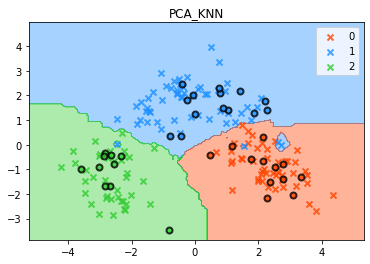

In [46]:
draw_decision_region(pipe.named_steps["knn"],
                     Xtrain_int2,
                     y_train,
                     Xtest_int2,
                     y_test,
                     title="PCA_KNN")